In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

/work/ngkuissi/.conda/envs/learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up base model

In [2]:
reasoning_model_id = "HuggingFaceH4/zephyr-7b-beta"
reasoning_tokenizer = AutoTokenizer.from_pretrained(reasoning_model_id)
reasoning_model = AutoModelForCausalLM.from_pretrained(
    reasoning_model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)
reasoning_model.eval()

Loading checkpoint shards: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4

## Setting up reward model

In [3]:
reward_model_id = "OpenAssistant/reward-model-deberta-v3-large"
reward_tokenizer = AutoTokenizer.from_pretrained(reward_model_id)

In [4]:
reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_id
).to("cuda")
reward_model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

## Get output

### Calculate the score at each step proposed by our model output

In [5]:
def get_prm_score(prompt, model_output,
                  reward_model=reward_model, tokenizer=reward_tokenizer, device="cuda"):
    steps = model_output.split(". ")
    total_score = 0.0

    for i in range(1, len(steps)+1):
        partial = prompt + '\n' + ". ".join(model_output[:i])
        inputs = tokenizer(partial, return_tensors="pt").to(device)
        with torch.inference_mode():
            score = reward_model(**inputs).logits[0].item()
        total_score += score
        
    return total_score/len(steps) if steps else 0.0

### Beam Search Algorithm

In [10]:
def beam_search(prompt, 
    reasoning_model=reasoning_model, reasoning_tokenizer=reasoning_tokenizer,
    reward_model=reward_model, reward_tokenizer=reward_tokenizer,
    total_beams = 4, beam_size= 2, max_step=4
):
    assert total_beams % beam_size == 0, "total_beams must be divisible by beam_size"
    device = reasoning_model.device

    prompt = f"<|system|>\nYou are a helpful assistant.\n<|user|>\n{prompt}\n<|assistant|>\n"

    graph = nx.DiGraph()
    node_counter = 0
    beams = []

    ## initial run
    input_ids = reasoning_tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    outputs = reasoning_model.generate(
        input_ids=input_ids, max_new_tokens=128, do_sample=False,
        num_beams=total_beams, temperature=0.9, num_return_sequences=total_beams, pad_token_id=reasoning_tokenizer.eos_token_id
    )
    for i in range(total_beams):
        generated_text = reasoning_tokenizer.decode(outputs[i], skip_special_tokens=True)
        model_completion = generated_text.replace(prompt, "").strip()
        score = get_prm_score(prompt, model_completion)
        node_id = f"0-{i}"
        graph.add_node(node_id, label=model_completion[:40]+"...", score=score)
        beams.append((generated_text, score, node_id))

    # all subsequent reasoning steps
    for step in range(1, max_step + 1):
        beams = sorted(beams, key = lambda x: x[1], reverse=True)[:beam_size]
        candidates = []

        for parent_text, _, parent_id in beams:
            input_ids = reasoning_tokenizer(parent_text, return_tensors="pt").input_ids.to(device)
            children = reasoning_model.generate(
                input_ids=input_ids, max_new_tokens=64, do_sample=False,
                num_beams=(total_beams//beam_size), num_return_sequences=(total_beams//beam_size),
                pad_token_id=reasoning_tokenizer.eos_token_id)

            for i in range(total_beams//beam_size):
                child_text = reasoning_tokenizer.decode(children[i], skip_special_tokens=True)
                completion = child_text.replace(parent_text, "").strip()
                score = get_prm_score(parent_text, completion) # to change
                node_id = f"{step}-{i}-{parent_id}"
                graph.add_node(node_id, label=completion[:40]+"...", score=score)
                graph.add_edge(parent_id, node_id)
                candidates.append((child_text, score, node_id))

        beams = candidates
    
    return beams, graph
    

## Visualization

In [11]:
def plot_trace_graph_tree_clean(graph, figsize=(14, 8), title="Beam Search Tree (PRM-Guided)"):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import networkx as nx
    import textwrap

    try:
        pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
    except:
        pos = nx.spring_layout(graph, seed=42)

    scores = nx.get_node_attributes(graph, 'score')
    labels = nx.get_node_attributes(graph, 'label')
    node_colors = [scores[n] for n in graph.nodes()]
    node_order = list(graph.nodes())

    fig, ax = plt.subplots(figsize=figsize)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, ax=ax, alpha=0.3)

    # Draw nodes with color based on PRM score (no edge color)
    for node in node_order:
        x, y = pos[node]
        score = scores.get(node, 0)
        fill_color = plt.cm.viridis((score - min(node_colors)) / (max(node_colors) - min(node_colors)))

        ax.scatter(x, y, s=800, c=[fill_color], edgecolors='black', linewidths=1, zorder=5)

        # Shortened label below node
        text = textwrap.shorten(labels.get(node, ""), width=50, placeholder="...")
        ax.text(x, y - 30, text, ha='center', va='top', fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.4), zorder=10)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                               norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array(node_colors)
    fig.colorbar(sm, ax=ax, label="PRM Score")

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [12]:
prompt = "Roger has 5 tennis balls. He buys 2 cans of 3 tennis balls each. How many tennis balls does he have now?"
beams, graph = beam_search(prompt, reasoning_model, reasoning_tokenizer, reward_model, reward_tokenizer)

for i, (text, score, _) in enumerate(beams):
    print(f"--- Final Beam {i+1} ---\nScore: {score:.2f}\n{text}\n")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Final Beam 1 ---
Score: 5.40
<|system|>
You are a helpful assistant.
<|user|>
Roger has 5 tennis balls. He buys 2 cans of 3 tennis balls each. How many tennis balls does he have now?
<|assistant|>
Roger originally had 5 tennis balls. When he bought 2 cans, each containing 3 tennis balls, he received a total of 6 tennis balls from the cans (2 cans x 3 tennis balls per can = 6 tennis balls). So, in total, Roger now has 11 tennis balls (5 tennis balls originally + 6 tennis balls from the cans = 11 tennis balls).

Here's the math:

Original tennis balls: 5
Tennis balls from cans: 2 cans x 3 tennis balls per can = 6
Total tennis balls: Original tennis balls + Tennis balls from cans = 5 + 6 = 11

So, Roger has a total of 11 tennis balls now.

--- Final Beam 2 ---
Score: 5.64
<|system|>
You are a helpful assistant.
<|user|>
Roger has 5 tennis balls. He buys 2 cans of 3 tennis balls each. How many tennis balls does he have now?
<|assistant|>
Roger originally had 5 tennis balls. When he bou

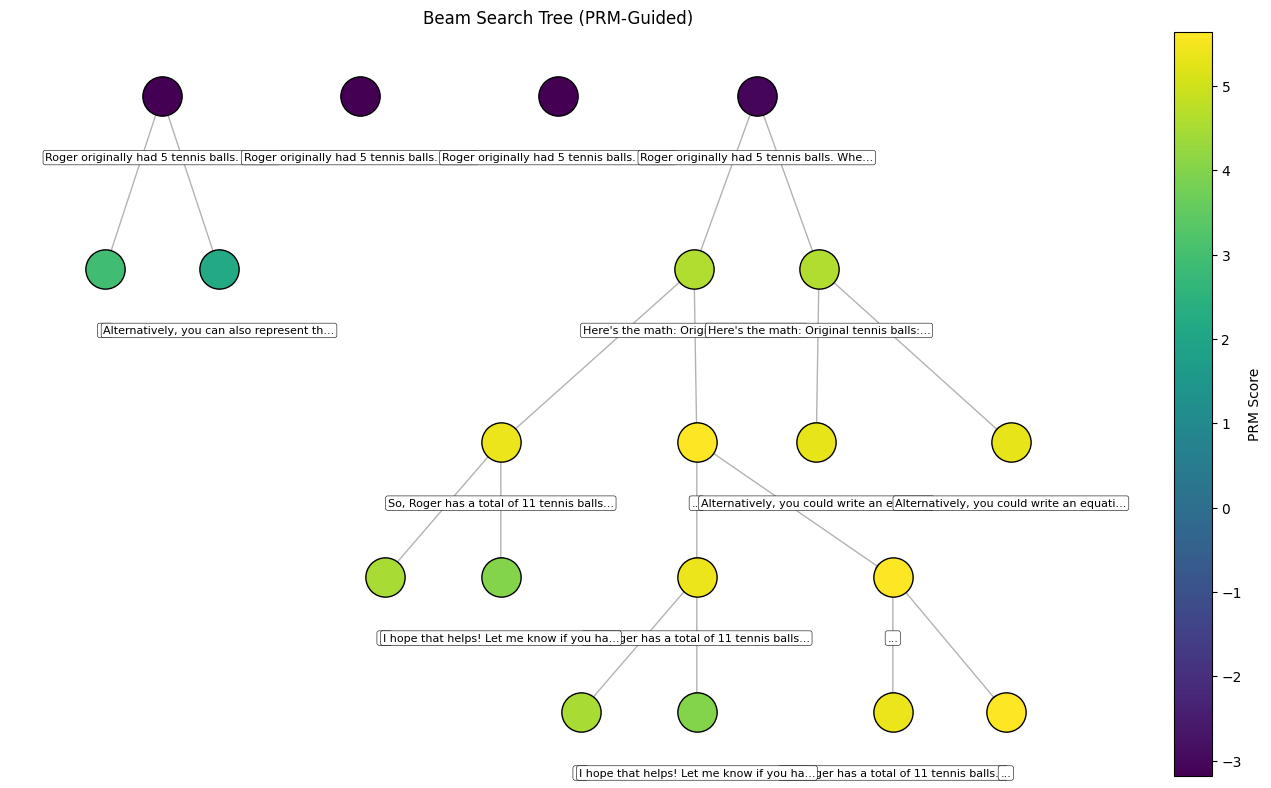

In [13]:
plot_trace_graph_tree_clean(graph)